In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy

import gamspec

然后，我们希望导入预定义的管道网（分析流程）。

In [2]:
# 用于寻峰的分支
sav = gamspec.SavitzkySmoother(3, 3)
convol = gamspec.SecondConvolutionPeakSearcher(20)
# peakfilter = gamspec.PeakSearcher()
convol._min_height_ratio = 0.6
convol._min_height = 100
convol._min_area = 10000
convol._min_area_ratio = 3
searcher = gamspec.CovarianceSearcher(10, 4, 'inverse')
searcher._merge_mode = "Old"
searcher._min_height_ratio = 0.6
searcher._min_height = 100
searcher._min_area = 10000
searcher._min_area_ratio = 3

# def func(spectrum):
#     for region in spectrum.regions:
#         for peak in region._peaks:
#             if 'stderr' not in peak:
#                 peak['stderr'] = 4
#     return spectrum

# def func(spectrum):
#     for i, peak in enumerate(spectrum.peaks):
#         j = 0
#         while (i+j<len(spectrum.peaks)) and ('stderr' not in spectrum.peaks[i+j].keys()):
#             j += 1
#         k = 0
#         while (i-k >= 0) and ('stderr' not in spectrum.peaks[i-k].keys()):
#             k += 1
#         spectrum.peaks[i]['stderr'] = (spectrum.peaks[i+j]['stderr'] + spectrum.peaks[i-k]['stderr']) / 2

# opr = gamspec.Functionor(func)
ppeak = gamspec.Pipe([sav, convol, searcher])
fpeak = gamspec.Flow(ppeak, 0, 0, 1, 0)

# 用于平滑的分支
wavelet = gamspec.TranslationInvarianceWaveletSmoother('dmey', 'quadratic-soft', order=3)

# wavelet = gamspec.SavitzkySmoother(3, 4)
fsmooth = gamspec.Flow(wavelet, 0, 0, 1, 1)

# 两个分支合并
def combine(spec1, spec2):
    spec2.regions = deepcopy(spec1.regions)
    return spec2
comb = gamspec.Combinor(2, func=combine)
fcomb = gamspec.Flow(comb, 1, [0, 1], 2, 0)

# 剥谱
strp = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=False)
fstrip = gamspec.Flow(strp, 2, 0, 5, 0)


# 拟合，计算峰面积
fit = gamspec.RegionPeakFitter(3, equal_width=False, baseline=False)
ffit = gamspec.Flow(fit, 5, 0, 4, 0)

pipenet = gamspec.PipeNet([fpeak, fsmooth, fcomb, fstrip, ffit])
# pipenet([bench])

In [3]:
# spec = gamspec.Spectrum.from_MCNP('E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\Eu152sgl_benchmark_0.7789.out')
# searcher._merge_mode = "Old"
# spec1 = (spec >> sav >> convol >> searcher)

# spec2 = spec1  >> strp >> convol 

In [4]:
# %matplotlib widget
# # spec1 = gamspec.Spectrum.from_xml(r'E:\Gamut_dev\Eu152sgl_benchmark_1.11231.xml')
# plt.close()
# spec1.plot()
# # spec1.plot()
# spec1.plot_regions()
# # spec2.plot_peaks()
# # plt.xlim(100, )
# plt.legend()
# plt.show()

In [5]:
# x = y

In [19]:

import pathlib
from re import match

results_combined = []
files = pathlib.Path(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\\').glob("Eu152sgl_test_new_*.out")
specs = []
for file in files:
    energy = match(r'Eu152sgl_test_new_(\d+\.\d+).out', file.name).group(1)
    energy = float(energy) 

    # if energy < 0.5:
    #     continue
    
    if pathlib.Path(file.stem+'.xlsx').exists():
        print("read existing file:" + file.stem+'.xlsx')
        df = pd.read_excel(file.stem+'.xlsx')
        spec = gamspec.Spectrum.from_xml(file.stem+'.xml')
        specs.append(spec)
    else:
        print("read new file:" + str(file))
        spectrum = gamspec.Spectrum.from_MCNP(str(file))
        pipenet([spectrum])
        spec = pipenet.get_node(4)[0]
        spec.export_to_xml(file.stem+'.xml')
        specs.append(spec)
        df = spec.export_to_pandas()
        df.to_excel(file.stem+'.xlsx')

    aim = df[(df['energy'] - energy*1000).abs()<2]
    aim['set_energy'] = energy
    results_combined.append(aim)

read existing file:Eu152sgl_test_new_0.03952.xlsx
read existing file:Eu152sgl_test_new_0.04012.xlsx
read existing file:Eu152sgl_test_new_0.0454.xlsx
read existing file:Eu152sgl_test_new_0.12178.xlsx
read existing file:Eu152sgl_test_new_0.2447.xlsx
read existing file:Eu152sgl_test_new_0.34428.xlsx
read existing file:Eu152sgl_test_new_0.36779.xlsx
read existing file:Eu152sgl_test_new_0.41111.xlsx
read existing file:Eu152sgl_test_new_0.44398.xlsx
read existing file:Eu152sgl_test_new_0.68868.xlsx
read existing file:Eu152sgl_test_new_0.7789.xlsx
read existing file:Eu152sgl_test_new_0.86739.xlsx
read existing file:Eu152sgl_test_new_0.96413.xlsx
read existing file:Eu152sgl_test_new_1.08591.xlsx
read existing file:Eu152sgl_test_new_1.0897.xlsx
read existing file:Eu152sgl_test_new_1.11212.xlsx
read existing file:Eu152sgl_test_new_1.21295.xlsx
read existing file:Eu152sgl_test_new_1.29912.xlsx


C:\Users\alber\AppData\Local\Temp\ipykernel_5648\1252770860.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aim['set_energy'] = energy
C:\Users\alber\AppData\Local\Temp\ipykernel_5648\1252770860.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aim['set_energy'] = energy
C:\Users\alber\AppData\Local\Temp\ipykernel_5648\1252770860.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [21]:
results = pd.concat(results_combined)
results

,Unnamed: 0,left,right,energy,location,height,stderr,area,sig_area2,fitness,set_energy
3,3,64,142,39.285694,134,29432.937479,2.708089,1.997959e+05,1173.728817,0.987932,0.03952
3,3,64,144,38.406164,131,16006.922214,4.317724,1.732418e+05,11098.420134,0.997568,0.04012
4,4,64,144,40.165224,137,27122.614634,2.086780,1.418724e+05,6484.737182,0.997568,0.04012
4,4,63,170,45.442404,155,41178.885015,2.302586,2.376733e+05,1227.074475,0.982938,0.04540
8,8,36,444,121.961510,416,493605.700503,2.355165,2.914013e+06,3322.169246,0.997391,0.12178
8,8,625,851,244.802526,835,442277.035284,2.708583,3.002801e+06,3986.545746,0.999501,0.24470
10,10,1044,1198,344.482587,1175,322828.268369,2.937522,2.377073e+06,1802.972232,0.999813,0.34428
9,9,1136,1281,367.936719,1255,305205.117611,3.038587,2.324628e+06,1567.454447,0.994963,0.36779
6,6,1302,1431,411.326864,1403,273657.802714,3.119055,2.139542e+06,1537.146822,0.995959,0.41111
6,6,1399,1541,444.162648,1515,253893.030342,3.179866,2.023716e+06,1497.523280,0.996879,0.44398


In [12]:
energies = np.array([40.12, 45.40, 121.78, 244.70, 344.28, 367.79, 411.11, 443.98, 688.68, 778.90, 867.39, 964.13, 1085.91, 1089.70, 1112.12, 1212.95, 1299.12])
percentages = np.array([29.119E-2, 7.304E-2, 14.016E-2, 3.697E-2, 13.128E-2, 0.410E-2, 1.101E-2, 1.372E-2, 0.412E-2, 6.396E-2, 2.048E-2, 7.077E-2, 4.896E-2, 0.844E-2, 6.687E-2, 0.690E-2, 0.802E-2])
def energy_in_group(energy):
    if len(np.where(np.abs(energy-energies)<2)[0]) == 0:
        return None
    else:
        return np.where(np.abs(energy-energies)<2)[0][0]

energy_in_group(411)

6

In [13]:

files = pathlib.Path('E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\\').glob("Eu152sgl_benchmark_*.out")
files = [str(file) for file in files]

index = 0
analyzed = specs[index]
analyzed.label = 'analyzed'
origin = gamspec.Spectrum.from_MCNP(files[index])
origin.label = 'origin'

IndexError: list index out of range

In [ ]:
# searcher = gamspec.CovarianceSearcher(10, 4, 'inverse')
# searcher._min_height_ratio = 0.6
# searcher._min_height = 100
# searcher._min_area = 10000
# searcher._min_area_ratio = 2


origin = gamspec.Spectrum.from_xml(r'E:\Gamut_dev\Eu152sgl_benchmark_1.11231.xml')
# ppeak = gamspec.Pipe([sav, convol])
# out = ppeak(origin)
# smoothed = origin >> sav
# convoled = smoothed >> searcher


In [ ]:
convoled.peaks

NameError: name 'convoled' is not defined

In [33]:
%matplotlib widget
spec1 = gamspec.Spectrum.from_xml(r'E:\Gamut_dev\Eu152sgl_benchmark_1.11231.xml')
plt.close()
spec1.plot()
spec1.plot_regions()
spec1.plot_peaks()
# plt.xlim(100, )
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Gamut_dev\\Eu152sgl_benchmark_1.11231.xml'

In [31]:
# out = gamspec.Spectrum.from_MCNP(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\Eu152sgl_test_new_0.68868.out') \
out = gamspec.Spectrum.from_MCNP(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\Eu152sgl_test_new_0.12178.out') \
    >> gamspec.GaussPeakSearcher(2, 0.2)
    # >> gamspec.RegionPeakFitter(2)
out.peaks

[{'location': 87, 'area': -885.375},
 {'location': 105, 'area': 115887.0},
 {'location': 119, 'area': 45716.0},
 {'location': 419, 'area': 5130356.0}]

<Axes: xlabel='Energy (keV)', ylabel='Counts'>

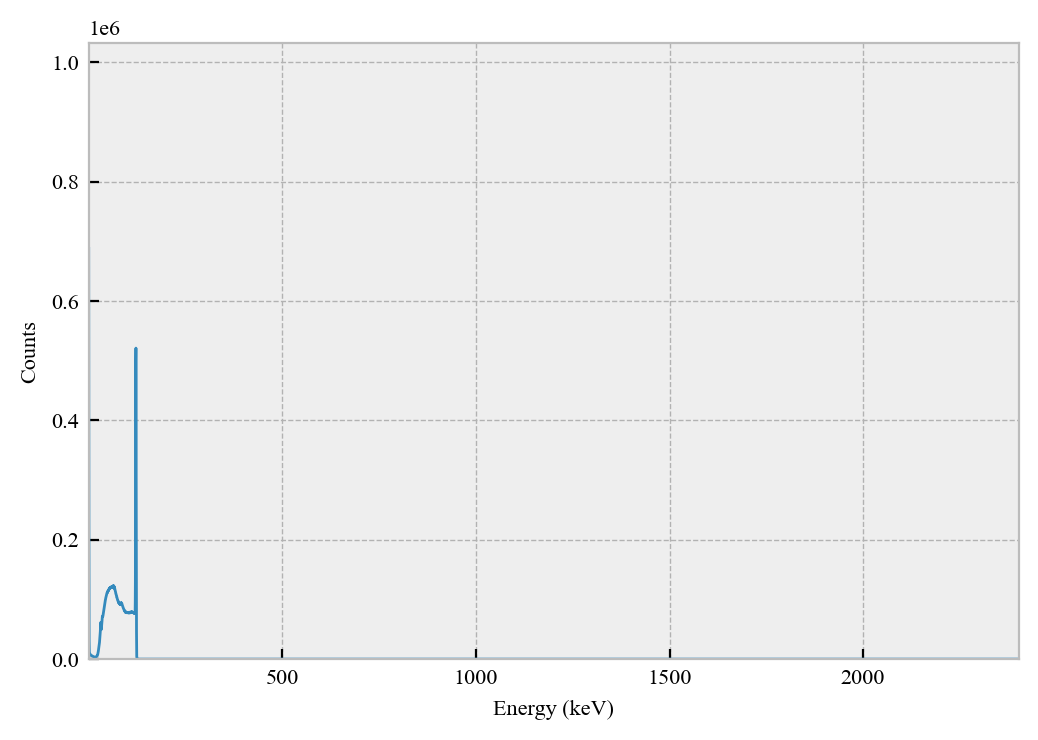

In [32]:
out.plot()